In [1]:
import polars as pl
import pandas as pd  # Needed for feature engineering modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

# Import feature engineering modules
from src.features.basic_features import BasicFeatureEngineer
from src.features.advanced_features import AdvancedFeatureEngineer
from src.features.feature_selector import FeatureSelector
from src.features.pipeline import FeatureEngineeringPipeline

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Configure Polars
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_rows(20)

print("✓ Imports successful!")
print(f"Project root: {project_root}")
print("\n💡 This notebook demonstrates feature engineering techniques for CTR prediction")


✓ Imports successful!
Project root: C:\Users\aloag\personal-study\ctr-prediction-system

💡 This notebook demonstrates feature engineering techniques for CTR prediction


# Feature Engineering for CTR Prediction

This notebook demonstrates various feature engineering techniques for CTR prediction:

1. **Basic Features**: Historical CTR, temporal features, counts
2. **Advanced Features**: Encoding for high-cardinality categoricals
3. **Feature Selection**: Removing redundant features
4. **Complete Pipeline**: End-to-end feature engineering

## Dataset
- **Source**: Avazu processed dataset
- **File**: `data/raw/avazu_processed.parquet`
- **Target**: `clicked` (binary: 0 or 1)


In [2]:
# Load raw data (using Polars for fast loading)
filepath = project_root / "data" / "raw" / "avazu_processed.parquet"

print("Loading raw dataset...")
if not filepath.exists():
    print(f"⚠️  File not found: {filepath}")
    print("\nPlease run:")
    print("  python scripts/download_avazu.py --load --sample-frac 0.1 --output data/raw/avazu_processed.parquet")
else:
    # Load with Polars (fast!)
    df_raw = pl.read_parquet(filepath)
    print(f"✓ Loaded {df_raw.height:,} rows, {df_raw.width} columns")
    
    # Convert to pandas for feature engineering (our modules use pandas)
    # For large datasets, you might want to sample first
    sample_size = min(50000, df_raw.height)  # Sample 500K rows for faster processing
    if df_raw.height > sample_size:
        print(f"⚠️  Sampling {sample_size:,} rows for faster feature engineering...")
        df_raw = df_raw.sample(n=sample_size, seed=42)
    
    df = df_raw.to_pandas()
    print(f"✓ Working with {len(df):,} rows")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Ensure timestamp is datetime
    if 'timestamp' in df.columns:
        if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
            df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nFirst few rows:")
    display(df.head())


Loading raw dataset...
✓ Loaded 2,021,448 rows, 32 columns
⚠️  Sampling 50,000 rows for faster feature engineering...
✓ Working with 50,000 rows
Memory usage: 42.35 MB

Columns: ['user_id', 'ad_id', 'device', 'placement', 'timestamp', 'hour', 'day_of_week', 'is_weekend', 'date', 'clicked', 'id', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']

First few rows:


,user_id,ad_id,device,placement,timestamp,hour,day_of_week,is_weekend,date,clicked,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,a99f214a_bb88ee45,19251,desktop,header,2014-10-21 08:00:00,8,1,0,2014-10-21,0,...,1,0,19251,320,50,2201,3,35,-1,43
1,a99f214a_6cfdc611,17914,desktop,header,2014-10-21 03:00:00,3,1,0,2014-10-21,1,...,1,0,17914,320,50,2043,2,39,100083,32
2,a99f214a_8de5d7c1,19251,desktop,header,2014-10-21 09:00:00,9,1,0,2014-10-21,0,...,1,0,19251,320,50,2201,3,35,-1,43
3,a99f214a_f6c9b3af,15703,desktop,header,2014-10-21 06:00:00,6,1,0,2014-10-21,0,...,1,0,15703,320,50,1722,0,35,-1,79
4,a99f214a_09f0cc07,16208,desktop,sidebar,2014-10-21 07:00:00,7,1,0,2014-10-21,0,...,1,0,16208,320,50,1800,3,167,100081,23


## 1. Basic Feature Engineering

Create fundamental features:
- Historical CTR (user, ad, device level)
- Temporal features (hour, day, month, business hours)
- Count features (impressions, time since last click)
- Interaction features


In [3]:
# Create basic features
if 'df' in locals():
    print("=" * 60)
    print("BASIC FEATURE ENGINEERING")
    print("=" * 60)
    
    # Initialize feature engineer
    basic_engineer = BasicFeatureEngineer(target_col='clicked')
    
    # Create all basic features
    df_basic = basic_engineer.fit_transform(df.copy())
    
    print(f"\n✓ Basic features created!")
    print(f"Original columns: {len(df.columns)}")
    print(f"After basic features: {len(df_basic.columns)}")
    print(f"New features added: {len(df_basic.columns) - len(df.columns)}")
    
    # Show new features
    new_features = [col for col in df_basic.columns if col not in df.columns]
    print(f"\nNew features ({len(new_features)}):")
    for i, feat in enumerate(new_features[:20], 1):
        print(f"  {i}. {feat}")
    if len(new_features) > 20:
        print(f"  ... and {len(new_features) - 20} more")
    
    # Show example of historical CTR features
    if 'ctr_user_id_user' in df_basic.columns:
        print(f"\nExample: User Historical CTR")
        print(f"  Mean: {df_basic['ctr_user_id_user'].mean():.4f}")
        print(f"  Min: {df_basic['ctr_user_id_user'].min():.4f}")
        print(f"  Max: {df_basic['ctr_user_id_user'].max():.4f}")
        print(f"  Sample values:")
        display(df_basic[['user_id', 'clicked', 'ctr_user_id_user']].head(10))


BASIC FEATURE ENGINEERING
Creating basic features...
✓ Created basic features. Total columns: 55

✓ Basic features created!
Original columns: 32
After basic features: 55
New features added: 23

New features (23):
  1. month
  2. day
  3. week_of_year
  4. is_business_hours
  5. time_of_day
  6. ctr_user_id_user
  7. impressions_user_id_user
  8. user_activity_level
  9. user_ctr_overall
  10. ctr_ad_id_ad
  11. impressions_ad_id_ad
  12. ad_impression_count
  13. ad_ctr_overall
  14. ctr_device_device
  15. impressions_device_device
  16. device_ctr_overall
  17. placement_ctr_overall
  18. time_since_last_impression
  19. time_since_last_click
  20. device_placement
  ... and 3 more

Example: User Historical CTR
  Mean: 0.1714
  Min: 0.0000
  Max: 1.0000
  Sample values:


,user_id,clicked,ctr_user_id_user
0,000c6715_714fcc99,0,0.1615
1,00171260_33eb0dc8,0,0.1615
2,0026fbdd_39bbc183,0,0.1615
3,00285e17_52cfeca8,0,0.1615
4,003311ae_64b854e7,0,0.1615
5,00356428_e859cf99,0,0.1615
6,003bd955_72be4fc4,0,0.1615
7,003c040a_259268cb,0,0.1615
8,0040b623_47944721,1,0.1615
9,0044cdc8_e06b47ee,0,0.1615


### 1.1 Understanding Historical CTR Features

Historical CTR features use **expanding windows** to avoid data leakage - they only use past data.


In [4]:
# Visualize how historical CTR features work
if 'df_basic' in locals() and 'user_id' in df_basic.columns:
    # Get a sample user to show the pattern
    sample_user = df_basic['user_id'].iloc[0]
    user_data = df_basic[df_basic['user_id'] == sample_user].sort_values('timestamp').head(20)
    
    print(f"Example: Historical CTR for user {sample_user}")
    print(f"Showing first 20 impressions:\n")
    
    display_cols = ['timestamp', 'clicked', 'ctr_user_id_user']
    if 'impressions_user_id_user' in user_data.columns:
        display_cols.append('impressions_user_id_user')
    
    display(user_data[display_cols].head(20))
    
    # Plot the evolution
    if len(user_data) > 5:
        fig, axes = plt.subplots(2, 1, figsize=(14, 8))
        
        # CTR over time
        axes[0].plot(range(len(user_data)), user_data['ctr_user_id_user'], 
                    marker='o', label='Historical CTR', linewidth=2)
        axes[0].axhline(y=df_basic['clicked'].mean(), color='r', linestyle='--', 
                      label='Global CTR', alpha=0.7)
        axes[0].set_title(f'Historical CTR Evolution for User {sample_user}', 
                         fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Impression Number')
        axes[0].set_ylabel('Historical CTR')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Actual clicks
        clicks = user_data['clicked'].values
        axes[1].bar(range(len(user_data)), clicks, alpha=0.7, color=['red' if c == 1 else 'blue' for c in clicks])
        axes[1].set_title('Actual Clicks', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Impression Number')
        axes[1].set_ylabel('Clicked (1=Yes, 0=No)')
        axes[1].set_ylim(-0.1, 1.1)
        axes[1].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
        
        print("\n💡 Notice how the historical CTR updates after each impression,")
        print("   using only past data to avoid data leakage!")


Example: Historical CTR for user 000c6715_714fcc99
Showing first 20 impressions:



,timestamp,clicked,ctr_user_id_user,impressions_user_id_user
0,2014-10-21 06:00:00,0,0.1615,0


## 2. Advanced Feature Engineering

Handle high-cardinality categorical features using:
- **Frequency Encoding**: How often does this value appear?
- **Target Encoding**: What's the average CTR for this value? (with CV to prevent leakage)
- **Feature Hashing**: Hash values to fixed number of features


In [5]:
# Advanced feature engineering
if 'df_basic' in locals():
    print("=" * 60)
    print("ADVANCED FEATURE ENGINEERING")
    print("=" * 60)
    
    # Identify high-cardinality features
    high_card_cols = []
    for col in df_basic.columns:
        if df_basic[col].dtype in ['object', 'int64']:
            n_unique = df_basic[col].nunique()
            if n_unique > 100 and col != 'clicked':
                high_card_cols.append(col)
                print(f"  {col}: {n_unique:,} unique values")
    
    if not high_card_cols:
        print("No high-cardinality features found (threshold: >100 unique values)")
        # Use user_id and ad_id as examples
        if 'user_id' in df_basic.columns:
            high_card_cols = ['user_id', 'ad_id']
            print(f"Using example columns: {high_card_cols}")
    
    # Create advanced features
    advanced_engineer = AdvancedFeatureEngineer(target_col='clicked', n_splits=5, random_state=42)
    df_advanced = advanced_engineer.fit_transform(df_basic.copy(), high_card_cols=high_card_cols)
    
    print(f"\n✓ Advanced features created!")
    print(f"Before: {len(df_basic.columns)} columns")
    print(f"After: {len(df_advanced.columns)} columns")
    print(f"New features added: {len(df_advanced.columns) - len(df_basic.columns)}")
    
    # Show encoding features
    encoding_features = [col for col in df_advanced.columns 
                        if any(x in col for x in ['_freq', '_target_enc', '_hash'])]
    print(f"\nEncoding features ({len(encoding_features)}):")
    for feat in encoding_features[:15]:
        print(f"  - {feat}")
    if len(encoding_features) > 15:
        print(f"  ... and {len(encoding_features) - 15} more")


ADVANCED FEATURE ENGINEERING
  user_id: 39,290 unique values
  ad_id: 461 unique values
  site_id: 953 unique values
  site_domain: 796 unique values
  app_id: 964 unique values
  device_id: 7,488 unique values
  device_ip: 38,381 unique values
  device_model: 2,481 unique values
  C14: 461 unique values
  C17: 154 unique values
  C20: 150 unique values
  impressions_user_id_user: 250 unique values
  impressions_ad_id_ad: 4,132 unique values
  ad_impression_count: 144 unique values
  impressions_device_device: 47,387 unique values
Encoding 15 high-cardinality features...

✓ Advanced features created!
Before: 55 columns
After: 160 columns
New features added: 105

Encoding features (105):
  - user_id_freq
  - user_id_freq_norm
  - user_id_target_enc
  - user_id_hash_0
  - user_id_hash_1
  - user_id_hash_2
  - user_id_hash_3
  - user_id_hash_4
  - user_id_hash_5
  - user_id_hash_6
  - user_id_hash_7
  - user_id_hash_8
  - user_id_hash_9
  - ad_id_freq
  - ad_id_freq_norm
  ... and 90 more

### 2.1 Understanding Target Encoding

Target encoding uses cross-validation to prevent data leakage. Let's visualize how it works.


Target Encoding vs Simple Mean (with leakage):

Sample comparison:


,user_id,clicked,user_id_target_enc,user_simple_mean
0,000c6715_714fcc99,0,0.177406,0.0
1,00171260_33eb0dc8,0,0.177406,0.0
2,0026fbdd_39bbc183,0,0.177406,0.0
3,00285e17_52cfeca8,0,0.177406,0.0
4,003311ae_64b854e7,0,0.177406,0.0
5,00356428_e859cf99,0,0.177406,0.0
6,003bd955_72be4fc4,0,0.177406,0.0
7,003c040a_259268cb,0,0.177406,0.0
8,0040b623_47944721,1,0.177406,1.0
9,0044cdc8_e06b47ee,0,0.177406,0.0


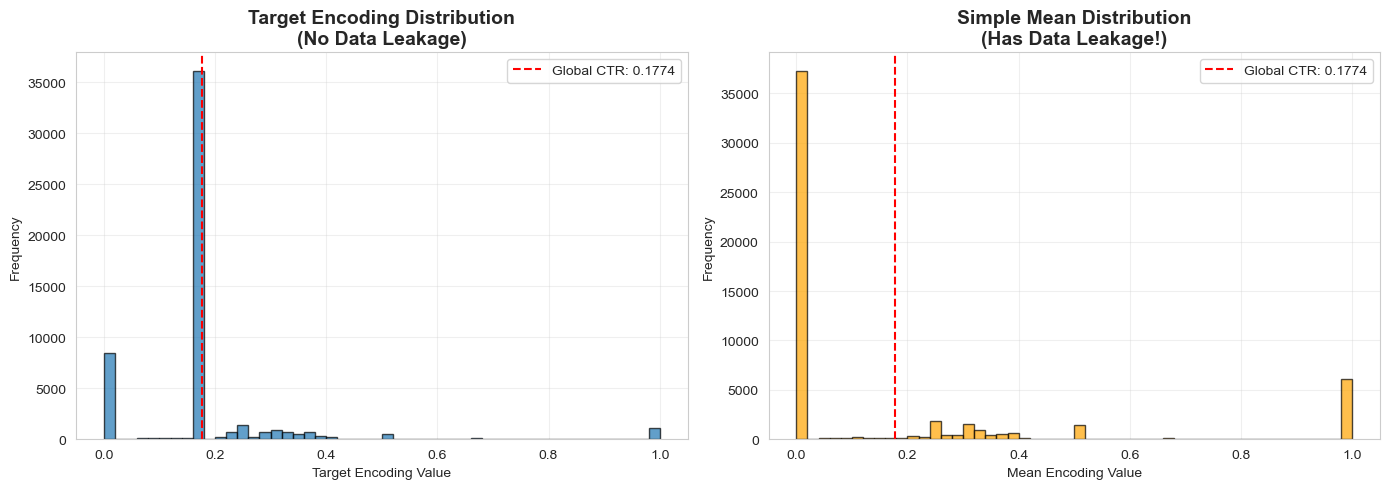


💡 Target encoding uses cross-validation to prevent data leakage.
   Simple mean encoding uses the same row's target value - this is leakage!


In [6]:
# Visualize target encoding
if 'df_advanced' in locals() and 'user_id_target_enc' in df_advanced.columns:
    # Compare target encoding with simple mean encoding (which has leakage)
    user_simple_mean = df_advanced.groupby('user_id')['clicked'].mean()
    df_advanced['user_simple_mean'] = df_advanced['user_id'].map(user_simple_mean)
    
    # Show comparison
    print("Target Encoding vs Simple Mean (with leakage):")
    print("\nSample comparison:")
    sample = df_advanced[['user_id', 'clicked', 'user_id_target_enc', 'user_simple_mean']].head(20)
    display(sample)
    
    # Plot distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Target encoding distribution
    axes[0].hist(df_advanced['user_id_target_enc'].dropna(), bins=50, alpha=0.7, edgecolor='black')
    axes[0].axvline(df_advanced['clicked'].mean(), color='r', linestyle='--', 
                   label=f'Global CTR: {df_advanced["clicked"].mean():.4f}')
    axes[0].set_title('Target Encoding Distribution\n(No Data Leakage)', 
                     fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Target Encoding Value')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Simple mean distribution (for comparison)
    axes[1].hist(df_advanced['user_simple_mean'].dropna(), bins=50, alpha=0.7, 
                edgecolor='black', color='orange')
    axes[1].axvline(df_advanced['clicked'].mean(), color='r', linestyle='--', 
                   label=f'Global CTR: {df_advanced["clicked"].mean():.4f}')
    axes[1].set_title('Simple Mean Distribution\n(Has Data Leakage!)', 
                     fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Mean Encoding Value')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Target encoding uses cross-validation to prevent data leakage.")
    print("   Simple mean encoding uses the same row's target value - this is leakage!")
    
    # Clean up
    df_advanced = df_advanced.drop('user_simple_mean', axis=1)


### 2.2 Frequency Encoding Example


Frequency Encoding Example:

Top 10 most frequent users:


,user_id_freq,clicked
user_id,,
a99f214a_6b9769f2,1483,0.243425
a99f214a_431b3174,703,0.301565
a99f214a_c6563308,357,0.383754
a99f214a_0489ce3f,334,0.359281
a99f214a_ddd2926e,322,0.363354
a99f214a_ceffea69,276,0.300725
a99f214a_75bb1b58,250,0.260000
a99f214a_a8536f3a,248,0.338710
a99f214a_1cf29716,226,0.318584


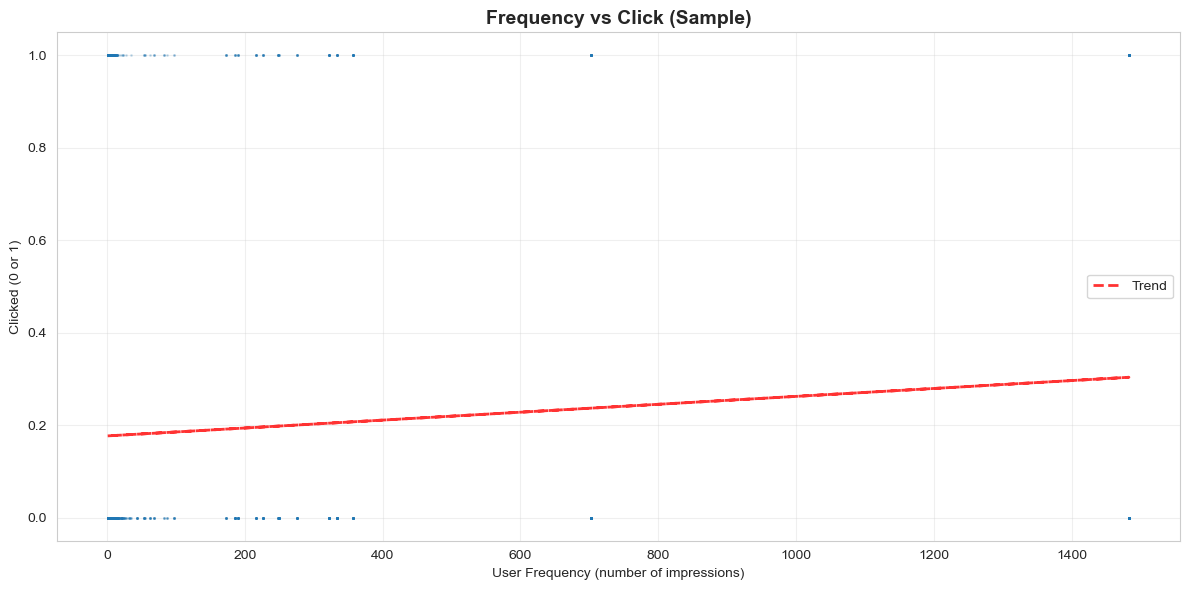


💡 Frequency encoding captures how common a value is.
   More frequent users/ads might have different CTR patterns.


In [7]:
# Frequency encoding visualization
if 'df_advanced' in locals() and 'user_id_freq' in df_advanced.columns:
    print("Frequency Encoding Example:")
    print("\nTop 10 most frequent users:")
    freq_stats = df_advanced.groupby('user_id').agg({
        'user_id_freq': 'first',
        'clicked': 'mean'
    }).sort_values('user_id_freq', ascending=False).head(10)
    
    display(freq_stats)
    
    # Plot frequency vs CTR
    plt.figure(figsize=(12, 6))
    
    # Sample for visualization (too many points otherwise)
    sample_size = min(10000, len(df_advanced))
    sample_df = df_advanced.sample(n=sample_size, random_state=42)
    
    plt.scatter(sample_df['user_id_freq'], sample_df['clicked'], 
               alpha=0.1, s=1)
    plt.xlabel('User Frequency (number of impressions)')
    plt.ylabel('Clicked (0 or 1)')
    plt.title('Frequency vs Click (Sample)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Add trend line
    if len(sample_df) > 100:
        from scipy import stats
        x = sample_df['user_id_freq'].values
        y = sample_df['clicked'].values
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x, p(x), "r--", alpha=0.8, linewidth=2, label='Trend')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Frequency encoding captures how common a value is.")
    print("   More frequent users/ads might have different CTR patterns.")


## 3. Feature Selection

Remove redundant and low-importance features.


In [8]:
# Feature selection
if 'df_advanced' in locals():
    print("=" * 60)
    print("FEATURE SELECTION")
    print("=" * 60)
    
    # Initialize feature selector
    feature_selector = FeatureSelector(target_col='clicked', random_state=42)
    
    # Apply feature selection
    df_selected = feature_selector.fit_transform(
        df_advanced.copy(),
        remove_low_variance=True,
        remove_correlated=True,
        select_by_importance=False  # Set to True to select top N features
    )
    
    print(f"\n✓ Feature selection complete!")
    print(f"Before: {len(df_advanced.columns)} columns")
    print(f"After: {len(df_selected.columns)} columns")
    print(f"Features removed: {len(df_advanced.columns) - len(df_selected.columns)}")
    
    # Show removed features
    removed_features = [col for col in df_advanced.columns if col not in df_selected.columns]
    if removed_features:
        print(f"\nRemoved features ({len(removed_features)}):")
        for feat in removed_features[:20]:
            print(f"  - {feat}")
        if len(removed_features) > 20:
            print(f"  ... and {len(removed_features) - 20} more")
    
    # Show correlation analysis (if we have numeric features)
    numeric_cols = df_selected.select_dtypes(include=[np.number]).columns.tolist()
    if 'clicked' in numeric_cols:
        numeric_cols.remove('clicked')
    
    if len(numeric_cols) > 1:
        print(f"\nAnalyzing correlations among {len(numeric_cols)} numeric features...")
        # Sample for correlation matrix (too large otherwise)
        sample_size = min(50000, len(df_selected))
        corr_sample = df_selected[numeric_cols[:20]].sample(n=sample_size, random_state=42)
        corr_matrix = corr_sample.corr().abs()
        
        # Find highly correlated pairs
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if corr_matrix.iloc[i, j] > 0.9:
                    high_corr_pairs.append((
                        corr_matrix.columns[i],
                        corr_matrix.columns[j],
                        corr_matrix.iloc[i, j]
                    ))
        
        if high_corr_pairs:
            print(f"\nHighly correlated pairs (>{0.9}):")
            for feat1, feat2, corr in high_corr_pairs[:10]:
                print(f"  {feat1} <-> {feat2}: {corr:.3f}")
        else:
            print("  ✓ No highly correlated pairs found (threshold: 0.9)")


FEATURE SELECTION
Applying feature selection...
Removed 14 low-variance features
Removed 27 highly correlated features (threshold=0.95)
✓ Feature selection complete. Final columns: 119

✓ Feature selection complete!
Before: 160 columns
After: 119 columns
Features removed: 41

Removed features (41):
  - day_of_week
  - is_weekend
  - C17
  - month
  - day
  - week_of_year
  - ctr_device_device
  - device_ctr_overall
  - placement_ctr_overall
  - device_placement_ctr
  - user_device_ctr
  - hour_placement_ctr
  - user_id_freq
  - user_id_freq_norm
  - ad_id_freq
  - ad_id_freq_norm
  - ad_id_target_enc
  - site_id_freq_norm
  - site_domain_freq
  - site_domain_freq_norm
  ... and 21 more

Analyzing correlations among 101 numeric features...
  ✓ No highly correlated pairs found (threshold: 0.9)


## 4. Complete Pipeline

Use the complete feature engineering pipeline for end-to-end processing.


In [9]:
# Complete pipeline example
if 'df' in locals():
    print("=" * 60)
    print("COMPLETE FEATURE ENGINEERING PIPELINE")
    print("=" * 60)
    
    # Create pipeline
    pipeline = FeatureEngineeringPipeline(
        target_col='clicked',
        create_basic_features=True,
        create_advanced_features=True,
        apply_feature_selection=True,
        random_state=42
    )
    
    # Fit and transform
    df_final = pipeline.fit_transform(
        df.copy(),
        remove_low_variance=True,
        remove_correlated=True,
        select_by_importance=False
    )
    
    print(f"\n✓ Pipeline complete!")
    print(f"Original: {len(df.columns)} columns")
    print(f"Final: {len(df_final.columns)} columns")
    print(f"Total features created: {len(df_final.columns) - len(df.columns)}")
    
    # Feature summary
    feature_cols = [col for col in df_final.columns if col != 'clicked']
    print(f"\nFinal feature columns ({len(feature_cols)}):")
    
    # Categorize features
    ctr_features = [f for f in feature_cols if 'ctr' in f.lower()]
    temporal_features = [f for f in feature_cols if f in ['hour', 'day_of_week', 'month', 'is_weekend', 'is_business_hours']]
    encoding_features = [f for f in feature_cols if any(x in f for x in ['_freq', '_target_enc', '_hash'])]
    count_features = [f for f in feature_cols if 'count' in f.lower() or 'impressions' in f.lower()]
    interaction_features = [f for f in feature_cols if '_' in f and ('device' in f or 'placement' in f or 'hour' in f)]
    other_features = [f for f in feature_cols if f not in ctr_features + temporal_features + encoding_features + count_features + interaction_features]
    
    print(f"\nFeature categories:")
    print(f"  Historical CTR: {len(ctr_features)}")
    print(f"  Temporal: {len(temporal_features)}")
    print(f"  Encoding: {len(encoding_features)}")
    print(f"  Counts: {len(count_features)}")
    print(f"  Interactions: {len(interaction_features)}")
    print(f"  Other: {len(other_features)}")
    
    # Show sample of final features
    print(f"\nSample features:")
    display(df_final[feature_cols[:10] + ['clicked']].head())


COMPLETE FEATURE ENGINEERING PIPELINE
FEATURE ENGINEERING PIPELINE
Input shape: (50000, 32)

Step 1: Creating basic features...
Creating basic features...
✓ Created basic features. Total columns: 55
  Shape after basic features: (54209, 55)

Step 2: Creating advanced features...
Encoding 15 high-cardinality features...
  Shape after advanced features: (54209, 160)

Step 3: Applying feature selection...
Applying feature selection...
Removed 14 low-variance features
Removed 27 highly correlated features (threshold=0.95)
✓ Feature selection complete. Final columns: 119
  Shape after feature selection: (54209, 119)

✓ Feature engineering complete!
  Final shape: (54209, 119)
  Features: 119

✓ Pipeline complete!
Original: 32 columns
Final: 119 columns
Total features created: 87

Final feature columns (118):

Feature categories:
  Historical CTR: 4
  Temporal: 2
  Encoding: 76
  Counts: 30
  Interactions: 53
  Other: 26

Sample features:


,user_id,ad_id,device,placement,timestamp,date,site_id,site_domain,site_category,app_id,clicked
0,000c6715_714fcc99,21652,desktop,header,2014-10-21 06:00:00,2014-10-21,85f751fd,c4e18dd6,50e219e0,54c5d545,0
1,00171260_33eb0dc8,21647,tablet,sidebar,2014-10-21 02:00:00,2014-10-21,85f751fd,c4e18dd6,50e219e0,a607e6a7,0
2,0026fbdd_39bbc183,19665,other,header,2014-10-21 08:00:00,2014-10-21,391b8861,6792a5e4,50e219e0,ecad2386,0
3,00285e17_52cfeca8,6558,desktop,header,2014-10-21 05:00:00,2014-10-21,85f751fd,c4e18dd6,50e219e0,03528b27,0
4,003311ae_64b854e7,21647,desktop,header,2014-10-21 04:00:00,2014-10-21,85f751fd,c4e18dd6,50e219e0,73206397,0


## 5. Manual Feature Creation Examples

Create custom features manually.


In [10]:
# Manual feature creation examples
if 'df' in locals():
    print("=" * 60)
    print("MANUAL FEATURE CREATION EXAMPLES")
    print("=" * 60)
    
    df_manual = df.copy()
    
    # Example 1: User-Ad interaction count
    print("\n1. User-Ad Interaction Count")
    df_manual['user_ad_pair'] = df_manual['user_id'].astype(str) + '_' + df_manual['ad_id'].astype(str)
    interaction_counts = df_manual.groupby('user_ad_pair').size()
    df_manual['user_ad_interaction_count'] = df_manual['user_ad_pair'].map(interaction_counts)
    print(f"   Created: user_ad_interaction_count")
    print(f"   Unique pairs: {df_manual['user_ad_pair'].nunique():,}")
    print(f"   Max interactions: {df_manual['user_ad_interaction_count'].max()}")
    
    # Example 2: Time-based features
    print("\n2. Time-based Features")
    if 'timestamp' in df_manual.columns:
        df_manual['hour_sin'] = np.sin(2 * np.pi * df_manual['hour'] / 24)
        df_manual['hour_cos'] = np.cos(2 * np.pi * df_manual['hour'] / 24)
        df_manual['day_of_week_sin'] = np.sin(2 * np.pi * df_manual['day_of_week'] / 7)
        df_manual['day_of_week_cos'] = np.cos(2 * np.pi * df_manual['day_of_week'] / 7)
        print(f"   Created: hour_sin, hour_cos, day_of_week_sin, day_of_week_cos")
        print(f"   💡 Cyclical encoding helps models understand time patterns")
    
    # Example 3: Aggregated statistics
    print("\n3. Aggregated Statistics")
    if 'user_id' in df_manual.columns:
        user_stats = df_manual.groupby('user_id').agg({
            'clicked': ['mean', 'std', 'sum']
        })
        user_stats.columns = ['user_ctr_mean', 'user_ctr_std', 'user_clicks_total']
        df_manual = df_manual.merge(user_stats, left_on='user_id', right_index=True, how='left')
        print(f"   Created: user_ctr_mean, user_ctr_std, user_clicks_total")
    
    # Example 4: Ratio features
    print("\n4. Ratio Features")
    if 'user_id' in df_manual.columns and 'ad_id' in df_manual.columns:
        # Ratio of user's clicks to ad's total clicks
        user_clicks = df_manual.groupby('user_id')['clicked'].sum()
        ad_clicks = df_manual.groupby('ad_id')['clicked'].sum()
        df_manual['user_clicks'] = df_manual['user_id'].map(user_clicks)
        df_manual['ad_clicks'] = df_manual['ad_id'].map(ad_clicks)
        df_manual['user_ad_click_ratio'] = df_manual['user_clicks'] / (df_manual['ad_clicks'] + 1)  # +1 to avoid division by zero
        print(f"   Created: user_ad_click_ratio")
    
    print(f"\n✓ Manual features created!")
    print(f"Original columns: {len(df.columns)}")
    print(f"After manual features: {len(df_manual.columns)}")
    print(f"New features: {len(df_manual.columns) - len(df.columns)}")
    
    # Show new features
    new_manual_features = [col for col in df_manual.columns if col not in df.columns]
    print(f"\nNew manual features:")
    for feat in new_manual_features:
        print(f"  - {feat}")


MANUAL FEATURE CREATION EXAMPLES

1. User-Ad Interaction Count
   Created: user_ad_interaction_count
   Unique pairs: 44,243
   Max interactions: 43

2. Time-based Features
   Created: hour_sin, hour_cos, day_of_week_sin, day_of_week_cos
   💡 Cyclical encoding helps models understand time patterns

3. Aggregated Statistics
   Created: user_ctr_mean, user_ctr_std, user_clicks_total

4. Ratio Features
   Created: user_ad_click_ratio

✓ Manual features created!
Original columns: 32
After manual features: 44
New features: 12

New manual features:
  - user_ad_pair
  - user_ad_interaction_count
  - hour_sin
  - hour_cos
  - day_of_week_sin
  - day_of_week_cos
  - user_ctr_mean
  - user_ctr_std
  - user_clicks_total
  - user_clicks
  - ad_clicks
  - user_ad_click_ratio


## 6. Save Processed Features

Save the engineered features for model training.


In [11]:
# Save processed features
if 'df_final' in locals():
    output_path = project_root / "data" / "processed" / "features_engineered.csv"
    
    print(f"Saving engineered features to: {output_path}")
    
    # Save as CSV (or parquet for large datasets)
    if len(df_final) > 1000000:
        # Use parquet for large datasets
        output_path = output_path.with_suffix('.parquet')
        df_final.to_parquet(output_path, index=False)
        print(f"✓ Saved as Parquet (large dataset)")
    else:
        df_final.to_csv(output_path, index=False)
        print(f"✓ Saved as CSV")
    
    print(f"Shape: {df_final.shape}")
    print(f"File size: {output_path.stat().st_size / 1024**2:.2f} MB")
    
    # Also save pipeline for future use
    pipeline_path = project_root / "data" / "processed" / "feature_pipeline.pkl"
    pipeline.save(str(pipeline_path))
    print(f"\n✓ Pipeline saved to: {pipeline_path}")
    print("   You can load it later with: FeatureEngineeringPipeline.load()")
else:
    print("⚠️  Run the pipeline first to create df_final")


Saving engineered features to: C:\Users\aloag\personal-study\ctr-prediction-system\data\processed\features_engineered.csv
✓ Saved as CSV
Shape: (54209, 119)
File size: 32.05 MB
✓ Pipeline saved to C:\Users\aloag\personal-study\ctr-prediction-system\data\processed\feature_pipeline.pkl

✓ Pipeline saved to: C:\Users\aloag\personal-study\ctr-prediction-system\data\processed\feature_pipeline.pkl
   You can load it later with: FeatureEngineeringPipeline.load()


## Summary

This notebook demonstrated:

1. ✅ **Basic Features**: Historical CTR, temporal, counts, interactions
2. ✅ **Advanced Features**: Frequency encoding, target encoding, feature hashing
3. ✅ **Feature Selection**: Removing redundant features
4. ✅ **Complete Pipeline**: End-to-end feature engineering
5. ✅ **Manual Features**: Custom feature creation examples

### Key Takeaways

- **Avoid Data Leakage**: Use expanding windows and cross-validation
- **Handle High-Cardinality**: Use encoding techniques (target encoding, hashing)
- **Feature Selection**: Remove redundant features to improve model performance
- **Document Features**: Keep track of what each feature represents

### Next Steps

- Use the engineered features for model training (Phase 3)
- Experiment with different feature combinations
- Monitor feature importance in trained models
